## Recursive feature elimination

* Process 
  * Build a model and calculate feature importance (model 1)
  * Remove the least important feature 
  * Rebuild a model (model 2)
  * Reevaluate the performance 
  * If drop in performance (model 1 - model 2) is bigger than the threshold, it is an important feature, so keep it. If not, remove the feature. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

# Classification

In [2]:
# load dataset
data = pd.read_csv('../datasets/dataset_1.csv')
data.shape

(50000, 301)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

## Remove constant and quasi-constant features

In [5]:
quasi_constant_feat = []

for feature in X_train.columns: 
    
    # determine predominant values
    predominant = (X_train[feature].value_counts()/np.float(len(X_train)))\
    .sort_values(ascending=False).values[0]
    
    if predominant > 0.998:
        quasi_constant_feat.append(feature)

X_train.drop(quasi_constant_feat, axis=1, inplace=True)
X_test.drop(quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 158), (15000, 158))

## Remove duplicated features

In [6]:
duplicated_feat = [] 

for i, col1 in enumerate(X_train.columns):
    for col2 in X_train.columns[i+1:]:
        if X_train[col1].equals(X_train[col2]):
            duplicated_feat.append(col2)
            
print(duplicated_feat)

['var_148', 'var_199', 'var_296', 'var_250', 'var_232', 'var_269']


In [7]:
X_train.drop(duplicated_feat, axis=1, inplace=True)
X_test.drop(duplicated_feat, axis=1, inplace=True)

## Build ML model with all features

In [8]:
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f'%(roc_full))

Test ROC AUC=0.827532


## Rank features by importance

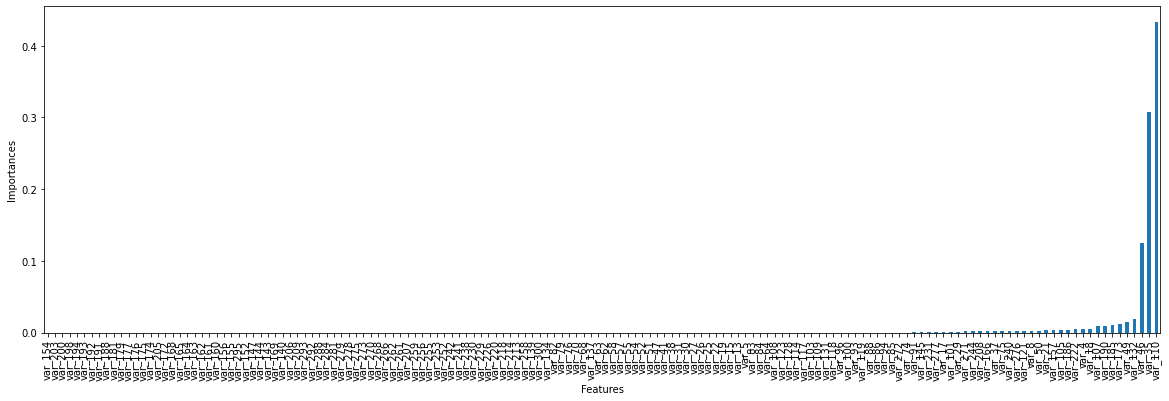

In [9]:
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns
features.sort_values(ascending=True, inplace=True)

# plot 
features.plot.bar(figsize=(20, 6))
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()

## Select features

In [12]:
features = list(features.index)

In [13]:
# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know where the loop is
count = 1

# now we loop over all the features, in order of importance:
# remember that features is this list are ordered
# by importance
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables, minus the feature to be evaluated
    # and also minus all features that were deemed to be removed
    
    # note that features_to_remove will be empty in the first rounds
    # but will have features as the loop proceeds
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with all the features
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # determine the drop in the roc-auc
    diff_roc = roc_full - roc_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        roc_full = roc_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  var_154 1  out of  152
New Test ROC AUC=0.8275385663137131
Full dataset ROC AUC=0.8275318972167823
Drop in ROC AUC=-6.669096930811413e-06
remove:  var_154

testing feature:  var_203 2  out of  152
New Test ROC AUC=0.8276405243718757
Full dataset ROC AUC=0.8275385663137131
Drop in ROC AUC=-0.00010195805816259895
remove:  var_203

testing feature:  var_200 3  out of  152
New Test ROC AUC=0.8274994560164579
Full dataset ROC AUC=0.8276405243718757
Drop in ROC AUC=0.00014106835541782825
remove:  var_200

testing feature:  var_198 4  out of  152
New Test ROC AUC=0.8275510002232452
Full dataset ROC AUC=0.8274994560164579
Drop in ROC AUC=-5.1544206787323965e-05
remove:  var_198

testing feature:  var_194 5  out of  152
New Test ROC AUC=0.8275221761602394
Full dataset ROC AUC=0.8275510002232452
Drop in ROC AUC=2.8824063005861156e-05
remove:  var_194

testing feature:  var_193 6  out of  152
New Test ROC AUC=0.8275526957563633
Full dataset R

New Test ROC AUC=0.8274888306755852
Full dataset ROC AUC=0.8274639628565211
Drop in ROC AUC=-2.486781906407831e-05
remove:  var_262

testing feature:  var_261 49  out of  152
New Test ROC AUC=0.8275143767078965
Full dataset ROC AUC=0.8274888306755852
Drop in ROC AUC=-2.5546032311307698e-05
remove:  var_261

testing feature:  var_207 50  out of  152
New Test ROC AUC=0.8275055599356828
Full dataset ROC AUC=0.8275143767078965
Drop in ROC AUC=8.816772213759982e-06
remove:  var_207

testing feature:  var_259 51  out of  152
New Test ROC AUC=0.8274739099841466
Full dataset ROC AUC=0.8275055599356828
Drop in ROC AUC=3.1649951536150134e-05
remove:  var_259

testing feature:  var_256 52  out of  152
New Test ROC AUC=0.8274988908387522
Full dataset ROC AUC=0.8274739099841466
Drop in ROC AUC=-2.4980854605560765e-05
remove:  var_256

testing feature:  var_255 53  out of  152
New Test ROC AUC=0.8274318607628204
Full dataset ROC AUC=0.8274988908387522
Drop in ROC AUC=6.703007593178434e-05
remove:  v

New Test ROC AUC=0.8275403748823726
Full dataset ROC AUC=0.827495499772516
Drop in ROC AUC=-4.4875109856623574e-05
remove:  var_5

testing feature:  var_83 97  out of  152
New Test ROC AUC=0.8274014542022377
Full dataset ROC AUC=0.8275403748823726
Drop in ROC AUC=0.0001389206801349907
remove:  var_83

testing feature:  var_84 98  out of  152
New Test ROC AUC=0.827529410434876
Full dataset ROC AUC=0.8274014542022377
Drop in ROC AUC=-0.00012795623263839317
remove:  var_84

testing feature:  var_64 99  out of  152
New Test ROC AUC=0.8275002472652464
Full dataset ROC AUC=0.827529410434876
Drop in ROC AUC=2.9163169629642383e-05
remove:  var_64

testing feature:  var_108 100  out of  152
New Test ROC AUC=0.8274789965835009
Full dataset ROC AUC=0.8275002472652464
Drop in ROC AUC=2.1250681745521582e-05
remove:  var_108

testing feature:  var_123 101  out of  152
New Test ROC AUC=0.8274760576594297
Full dataset ROC AUC=0.8274789965835009
Drop in ROC AUC=2.93892407121632e-06
remove:  var_123

te

New Test ROC AUC=0.8279009582588004
Full dataset ROC AUC=0.828572784997923
Drop in ROC AUC=0.000671826739122583
keep:  var_107

testing feature:  var_190 145  out of  152
New Test ROC AUC=0.8288239499704695
Full dataset ROC AUC=0.828572784997923
Drop in ROC AUC=-0.0002511649725465137
remove:  var_190

testing feature:  var_185 146  out of  152
New Test ROC AUC=0.8292781832927819
Full dataset ROC AUC=0.8288239499704695
Drop in ROC AUC=-0.0004542333223124251
remove:  var_185

testing feature:  var_173 147  out of  152
New Test ROC AUC=0.8263220778193183
Full dataset ROC AUC=0.8292781832927819
Drop in ROC AUC=0.0029561054734635883
keep:  var_173

testing feature:  var_49 148  out of  152
New Test ROC AUC=0.8290272443913177
Full dataset ROC AUC=0.8292781832927819
Drop in ROC AUC=0.00025093890146421494
remove:  var_49

testing feature:  var_132 149  out of  152
New Test ROC AUC=0.8292915214866434
Full dataset ROC AUC=0.8290272443913177
Drop in ROC AUC=-0.00026427709532572674
remove:  var_13

In [14]:
# now for comparison, we build a model with the selected features only

model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.829244
